In [2]:
#!curl -o data/fra-eng.zip http://www.manythings.org/anki/fra-eng.zip
#!unzip data/fra-eng.zip -d data/

### Reading Data and Tokenization

In [3]:
import pandas as pd

data = pd.read_csv("data/fra.txt",sep='\t',header= None,encoding="utf-8")
ang = list(data[0])
fra = list(data[1])

from spacy.lang.en import English
from spacy.lang.fr import French

nlp = English()
tokenizer = nlp.Defaults.create_tokenizer(nlp)
nlp_f = French()
tokenizer_f = nlp_f.Defaults.create_tokenizer(nlp_f)

ang = [['<S>'] + [token.string.strip() for token in tokenizer(text.lower())] + ['</S>'] for text in ang][:10000]

fra = [['<S>'] + [token.string.strip() for token in tokenizer_f(text.lower())] + ['</S>'] for text in fra][:10000]

print(ang[1000])
print(fra[1000])

['<S>', 'stay', 'thin', '.', '</S>']
['<S>', 'reste', 'mince', '!', '</S>']


### Training Word2Vec

In [4]:
from gensim.models import Word2Vec
import numpy as np

EMBEDDING_SIZE = 120
w2v = Word2Vec(ang, size=EMBEDDING_SIZE, window=10, min_count=1, negative=10, workers=10)
word_map = {}
word_map["<PAD>"] = 0
word_vectors = [np.zeros((EMBEDDING_SIZE,))]
for i, w in enumerate([w for w in w2v.wv.vocab]):
    word_map[w] = i+1
    word_vectors.append(w2v.wv[w])
word_vectors = np.vstack(word_vectors)

w2v = Word2Vec(fra, size=EMBEDDING_SIZE, window=10, min_count=1, negative=10, workers=10)
word_map_fr = {}
word_map_fr["<PAD>"] = 0
word_vectors_fr = [np.zeros((EMBEDDING_SIZE,))]
for i, w in enumerate([w for w in w2v.wv.vocab]):
    word_map_fr[w] = i+1
    word_vectors_fr.append(w2v.wv[w])
word_vectors_fr = np.vstack(word_vectors_fr)
i2w = dict(zip([*word_map_fr.values()],[*word_map_fr]))

### Padding, word2id and shifting

In [5]:
def pad(a,shift = False):
    shape = len(a)
    max_s = max([len(x) for x in a])
    if shift:
        token = np.zeros((shape,max_s+1),dtype = np.int)
        mask  =  np.zeros((shape,max_s+1),dtype = np.int)
        for i,o in enumerate(a):
            token[i,:len(o)] = o
            mask[i,:len(o)] = 1
        return token[:,1:],mask[:,1:],max_s       
    else:            
        token = np.zeros((shape,max_s),dtype = np.int)
        mask  =  np.zeros((shape,max_s),dtype = np.int)
        for i,o in enumerate(a):
            token[i,:len(o)] = o
            mask[i,:len(o)] = 1
        return token,mask,max_s 
        

In [6]:
ang_tok,ang_mask,ang_pl = pad([[word_map[w] for w in text] for text in ang])
fra_tok,fra_mask,fr_pl = pad([[word_map_fr[w] for w in text] for text in fra])
fra_toks_s,fra_mask_s,_ = pad([[word_map_fr[w] for w in text] for text in fra],shift = True)

### Positional encoder

In [7]:
#Source : https://www.tensorflow.org/tutorials/text/transformer
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)


### Seq2Seq model

In [8]:
from tensorflow.keras import layers,Model
from tensorflow.keras.initializers import Constant
import tensorflow as tf

class S2S(tf.keras.Model):
    def __init__(self,Win,Wout,pl_in,pl_out,i2w):
      
        super(S2S, self).__init__() 
        
        self.nv_in = Win.shape[0]
        self.r = Win.shape[1]
        self.nv_out = Wout.shape[0]
        self.pl_in = pl_in
        self.pl_out = pl_out
        
        self.i2w = i2w
        
        self.positional_in = positional_encoding(self.pl_in,self.r)
        self.positional_out = positional_encoding(self.pl_out,self.r)
        
        self.Win = layers.Embedding(self.nv_in,self.r)
        self.Win.build((None, ))
        self.Win.set_weights([Win])
        self.Win.trainable = True

        self.Wout = layers.Embedding(self.nv_out,self.r)
        self.Wout.build((None, ))
        self.Wout.set_weights([Wout])
        self.Wout.trainable = True
                    
        #### Encoder #####
        
        self.attention = layers.Attention(use_scale=True)
        self.attention.build((None,self.r))
        self.attention.scale = self.attention.add_weight(
            name='scale',
            shape=(),
            initializer=tf.keras.initializers.Constant(1/np.sqrt(self.r)),
            trainable=False)
        self.W1 = layers.Dense(self.r,activation="linear",use_bias=False,name = 'W1')
        self.W2 = layers.Dense(self.r,activation="linear",use_bias=False,name = 'W2')
        self.W3 = layers.Dense(self.r,activation="linear",use_bias=False,name = 'W3')
        
        self.FF = layers.Dense(self.r,activation = "relu")
        self.FF2 = layers.Dense(self.r)
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        #### Decoder #####
        
        self.attention2 = layers.Attention(use_scale=True)
        self.attention2.build((None,self.r))
        self.attention2.scale = self.attention2.add_weight(
            name='scale',
            shape=(),
            initializer=tf.keras.initializers.Constant(1/np.sqrt(self.r)),
            trainable=False)
        self.W12 = layers.Dense(self.r,activation="linear",use_bias=False,name = 'W12')
        self.W22 = layers.Dense(self.r,activation="linear",use_bias=False,name = 'W22')
        self.W32 = layers.Dense(self.r,activation="linear",use_bias=False,name = 'W32')
        
        self.attention3 = layers.Attention(use_scale=True)
        self.attention3.build((None,self.r))
        self.attention3.scale = self.attention3.add_weight(
            name='scale',
            shape=(),
            initializer=tf.keras.initializers.Constant(1/np.sqrt(self.r)),
            trainable=False)
        self.W13 = layers.Dense(self.r,activation="linear",use_bias=False,name = 'W13')
        self.W23 = layers.Dense(self.r,activation="linear",use_bias=False,name = 'W23')
        self.W33 = layers.Dense(self.r,activation="linear",use_bias=False,name = 'W33')
        
        self.FF2 = layers.Dense(self.r,activation = "relu")
        self.FF22 = layers.Dense(self.r)
        
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm4 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm5 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        #### Prediction ####
        self.mapper1 = layers.Dense(self.r,activation = "linear")
        self.mapper2 = layers.Dense(self.nv_out,activation = "softmax")

    @tf.function
    def call(self,x_tok,x_mask,y_tok,y_mask):
        
        x = self.Win(x_tok)
        x_mask = tf.cast(x_mask,dtype=bool)
        x += self.positional_in
        
        y = self.Wout(y_tok)
        y_mask = tf.cast(y_mask,dtype=bool)
        y += self.positional_out
        
        x_dec = self.encoder(x,x_mask)  
        
        end_dec_output = self.decoder(x_dec,x_mask,y,y_mask)
        
        probs = self.mapper2(self.mapper1(end_dec_output))
        
        return probs

    def encoder(self,x,x_mask):    

        x += self.attention([self.W1(x),self.W2(x),self.W3(x)],mask = [x_mask,x_mask])
        x = self.layernorm1(x)
        
        x += self.FF2(self.FF(x))
        x = self.layernorm2(x)
        
        return x
        
    def decoder(self,x,x_mask,y,y_mask):    

        y += self.attention2([self.W12(y),self.W22(y),self.W32(y)],mask = [y_mask,y_mask])
        y = self.layernorm3(y)
        
        y += self.attention3([self.W13(y),self.W23(x),self.W33(x)],mask = [y_mask,x_mask])
        y = self.layernorm4(y)
        
        y += self.FF2(self.FF(y))
        y = self.layernorm5(y)
            
        return y   
    
    def generate(self,start_emb,stop_emb,x,x_mask):
        aout = []
        tok = [start_emb]
        
        x = tf.expand_dims(x,axis=0)
        x_mask = tf.expand_dims(x_mask,axis=0)
                
        for i in range(10):
            y = tf.expand_dims(tf.constant(tok),axis=0)
            y = tf.pad(y, tf.constant([[0, 0], [0, self.pl_out-len(tok)]]), "CONSTANT")

            y_mask = tf.expand_dims(tf.constant([1 for i in range(len(tok))]),axis=0)
            y_mask = tf.pad(y_mask, tf.constant([[0, 0], [0, self.pl_out-len(tok)]]), "CONSTANT")

            probs = model(x,x_mask,y,y_mask)
            probs = tf.squeeze(tf.gather(probs, [i+1], axis=1))
            val,argval = tf.nn.top_k(probs, k=2, sorted=True, name=None)
            x_out = argval.numpy()[0]
            aout.append(self.i2w[x_out])
            tok.append(x_out)
        
        return aout



### Function for optim

In [9]:
#@tf.function
def mask_pred(mask,pos):
    
    pred_mask = tf.ones((mask.shape[0],pos),dtype=tf.dtypes.int32)

    paddings = tf.constant([[0, 0], [0, mask.shape[1]-pos]])
    
    pred_mask = tf.pad(pred_mask, paddings, "CONSTANT")
    
    return mask * pred_mask

#@tf.function
def compute_loss(model,loss_f,x,x_mask,y,y_mask):
    
    pro = []
    for t in range(fr_pl-1):
        res = model(x,x_mask,y,mask_pred(y_mask,t+1))
        res = tf.gather(res, [t+1], axis=1)
        pro.append(res)
    pro = tf.concat(pro,1) 
    
    y = tf.slice(y,[0,1],[y.shape[0],y.shape[1]-1])
    y_onehot = tf.one_hot(y,depth = word_vectors_fr.shape[0])

    y_mask = tf.slice(y_mask,[0,1],[y_mask.shape[0],y_mask.shape[1]-1])
    y_mask = tf.cast(y_mask,dtype=bool)
    
    y_true= tf.boolean_mask(y_onehot,y_mask)

    y_pred = tf.boolean_mask(pro,y_mask) 
    
    return loss_f(y_true,y_pred),y_true,y_pred


#@tf.function
def compute_apply_gradients(model,loss_f,x,x_mask,y,y_mask,optimizer):

    with tf.GradientTape() as tape:
        
        loss,label,prediction= compute_loss(model, loss_f,x,x_mask,y,y_mask)
        
    gradients = tape.gradient(loss, model.trainable_variables)
    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss,label,prediction




### Split

In [10]:
batch_size = 128

X = np.hstack([ang_tok,ang_mask])
print(X.shape)
Y = np.hstack([fra_tok,fra_mask])
print(Y.shape)
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.80, random_state=101)


train_data = tf.data.Dataset.from_tensor_slices((X_train,Y_train)).batch(batch_size)

test_data = tf.data.Dataset.from_tensor_slices((X_test,Y_test)).batch(batch_size)


(10000, 18)
(10000, 30)


### Model declaration

In [11]:
model = S2S(word_vectors,word_vectors_fr,ang_pl,fr_pl,i2w)

### Losses

In [18]:
from tqdm.notebook import tqdm
import os

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name='test_accuracy')

loss_f = tf.keras.losses.CategoricalCrossentropy()
    

loss_f = tf.keras.losses.CategoricalCrossentropy()

tr_loss = []
te_loss = []
tr_acc = []
te_acc = []
 


### Optimizer

Text(0.5, 0, 'Train Step')

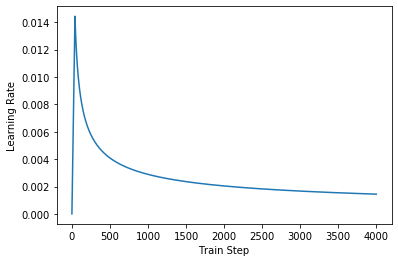

In [20]:
epochs = 30
#Source : https://www.tensorflow.org/tutorials/text/transformer    
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

learning_rate = CustomSchedule(EMBEDDING_SIZE, warmup_steps=40)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)


checkpoint_dir = 'training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 model=model)

import matplotlib.pyplot as plt

plt.plot(learning_rate(tf.range(4000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

### Training

In [21]:

for epoch in range(1, epochs + 1):
    print(epoch,flush=True,)

    for x,y in tqdm(train_data):
        
        x,x_mask = tf.split(x,2,axis=1)
        y,y_mask = tf.split(y,2,axis=1)
        
        loss,label,prediction = compute_apply_gradients(model,loss_f,x,x_mask,y,y_mask,optimizer)

        train_loss(loss)
        train_accuracy(label, prediction)
        
    for x,y in tqdm(test_data):

        x,x_mask = tf.split(x,2,axis=1)
        y,y_mask = tf.split(y,2,axis=1)

        loss,label,prediction = compute_loss(model,loss_f,x,x_mask,y,y_mask)
        test_loss(loss)
        test_accuracy(label, prediction)
                
    print(" ".join(ang[1000]))
    print(" ".join(model.generate(word_map_fr["<S>"],word_map_fr["</S>"],ang_tok[1000,:],ang_mask[1000,:])))
    
    print(" ".join(ang[5000]))
    print(" ".join(model.generate(word_map_fr["<S>"],word_map_fr["</S>"],ang_tok[5000,:],ang_mask[5000,:])))
    
    print(
    f'Loss: {train_loss.result()}, '
    f'Accuracy: {train_accuracy.result() * 100}, '
    f'Test Loss: {test_loss.result()}, '
    f'Test Accuracy: {test_accuracy.result() * 100}')
    
    tr_loss.append(train_loss.result())
    te_loss.append(test_loss.result())
    tr_acc.append(train_accuracy.result())
    te_acc.append(test_accuracy.result())
    if epoch % 2 == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)



1


KeyboardInterrupt: 

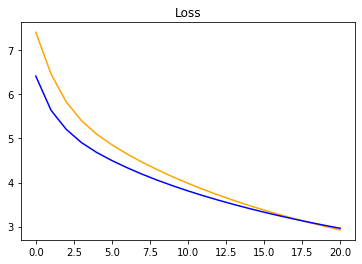

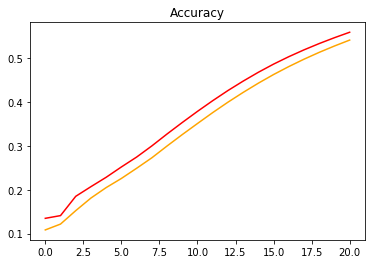

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(tr_loss, c="orange")
plt.plot(te_loss, c="blue")
plt.title("Loss")
plt.show()

plt.clf()
plt.plot(tr_acc, c="orange")
plt.plot(te_acc, c="red")
plt.title("Accuracy")
plt.show()